<a href="https://colab.research.google.com/github/Atfssene/FRASA/blob/main/Text_Summarization_Model_FRASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Summarization Model

In this notebook, we will create a model for text summarization task. TextRank and SumBasic will be our feature extraction from senteces to create a weights that will be feeded to a neural networks. Let's start!

## Import library

In [2]:
!pip install Sastrawi
# !pip install fasttext

     |████████████████████████████████| 215kB 29.2MB/s 


In [3]:
# Import library
import pandas as pd
import numpy as np
import re
import networkx as nx
import tensorflow as tf
import nltk
nltk.download('punkt')

from tensorflow.keras.optimizers import RMSprop
from nltk.tokenize import sent_tokenize, word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# For pre trained text embedding from FastText
# import gzip
# import fasttext
# import fasttext.util

factory = StopWordRemoverFactory()
stop_words = factory.get_stop_words()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Read data

In [4]:
train = tf.keras.utils.get_file('train.csv', 'https://raw.githubusercontent.com/Atfssene/FRASA/main/Text%20Summarization/train.csv')
test = tf.keras.utils.get_file('test.csv', 'https://raw.githubusercontent.com/Atfssene/FRASA/main/Text%20Summarization/test.csv')

df_train = pd.read_csv(train, dtype=object, converters={'labels':eval})
df_test = pd.read_csv(test, dtype=object, converters={'labels':eval})
df_train.info()
# df_test.info()

9879552/9872406 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ParserWarning: Both a converter and dtype were specified for column labels - only the converter will be used
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ParserWarning: Both a converter and dtype were specified for column labels - only the converter will be used
  """


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   labels      15012 non-null  object
 1   paragraphs  15012 non-null  object
 2   summary     15012 non-null  object
dtypes: object(3)
memory usage: 352.0+ KB


## TextRank

Load pretrained words embeddings

In [5]:
word_embeddings = {}
with open('/content/drive/MyDrive/model_summarization/cc.id.vec', encoding='utf-8') as file:
  for f in file:
      values = f.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      word_embeddings[word] = coefs

len(word_embeddings)
# <output> 400001

# For sorting return list
def sorting(e):
  return e[2]

TextRank Algorithm

In [6]:
def TextRank(sentences, processed):
    sentence_vectors = []
    for i in processed:
      if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split())+0.001)
      else:
        v = np.zeros((300,))
      sentence_vectors.append(v)

    sim_mat = np.zeros([len(sentences), len(sentences)])
    for i in range(len(sentences)):
      for j in range(len(sentences)):
        if i != j:
          sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,300), sentence_vectors[j].reshape(1,300))[0,0]

    nx_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank_numpy(nx_graph)

    ranked_sentences = sorted(([scores[i],i+1,s] for i,s in enumerate(sentences)), reverse=True)

    text_rank = []
    for index, sentence in enumerate(ranked_sentences):
      sentence.insert(1, index+1)
      text_rank.append(sentence)

    # Return list(TextRank weights, TextRank order, sentence order, sentence) => text_rank
    text_rank = sorted(text_rank,key=sorting)

    TR_weight = []
    TR_order = []
    for i in range(len(text_rank)):
      TR_weight.append(text_rank[i][0])
      TR_order.append(text_rank[i][1])
    # Just Return 2 list(TextRank weights, TextRank order)
    return TR_weight, TR_order

Example result from variable text_rank:


```
[0.05728266277281181, 7, 1, 'Jakarta, CNN Indonesia - - Dokter Ryan Thamrin, yang terkenal lewat acara Dokter Oz Indonesia, meninggal dunia pada Jumat (4 / 8) dini hari.']
[0.060217967742173646, 2, 2, 'Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu.']
[0.06045704497658339, 1, 3, 'Lula menuturkan, sakit itu membuat Ryan mesti vakum dari semua kegiatannya, termasuk menjadi pembawa acara Dokter Oz Indonesia.']
[0.05209530959721178, 15, 4, 'Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru, Riau untuk menjalani istirahat. "']
[0.05840185989845859, 4, 5, 'Setahu saya dia orangnya sehat, tapi tahun lalu saya dengar dia sakit.']
[0.05637943589724592, 10, 6, '( Karena) sakitnya, ia langsung pulang ke Pekanbaru, jadi kami yang mau jenguk juga susah.']
[0.05646634343163575, 9, 7, 'Barangkali mau istirahat, ya betul juga, kalau di Jakarta susah isirahatnya, " kata Lula kepada CNNIndonesia.com, Jumat (4 / 8).']
[0.058732876811454365, 3, 8, 'Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh.']
[0.055390279489910994, 12, 9, 'Dia juga tak tahu penyakit apa yang diderita Ryan. "']
[0.053688773306564144, 14, 10, 'Itu saya enggak tahu, belum sempat jenguk dan enggak selamanya bisa dijenguk juga.']
[0.05747455457427858, 6, 11, 'Enggak tahu berat sekali apa bagaimana, " tutur Ryan.']
[0.055102006046349405, 13, 12, 'Walau sudah setahun menderita sakit, Lula tak mengetahui apa penyebab pasti kematian Dr Oz Indonesia itu.']
[0.05763968547747263, 5, 13, 'Meski demikian, ia mendengar beberapa kabar yang menyebut bahwa penyebab Ryan meninggal adalah karena jatuh di kamar mandi.']
[0.05690594567038913, 8, 14, '“ Saya tidak tahu, barangkali penyakit yang dulu sama yang sekarang berbeda, atau penyebab kematiannya beda dari penyakit sebelumnya.']
[0.048397823134637225, 18, 15, 'Kita kan enggak bisa mengambil kesimpulan, " kata Lula.']
[0.056112156670864166, 11, 16, 'Ryan Thamrin terkenal sebagai dokter yang rutin membagikan tips dan informasi kesehatan lewat tayangan Dokter Oz Indonesia.']
[0.04974842217789095, 16, 17, 'Ryan menempuh Pendidikan Dokter pada tahun 2002 di Fakultas Kedokteran Universitas Gadjah Mada.']
[0.049506852324067645, 17, 18, 'Dia kemudian melanjutkan pendidikan Klinis Kesehatan Reproduksi dan Penyakit Menular Seksual di Mahachulalongkornrajavidyalaya University, Bangkok, Thailand pada 2004.']
```



## SumBasic

In [7]:
def SumBasic(sentences, processed):
  # Count the sum weights
  frequency = {}
  for text in processed:
    for word in word_tokenize(text):
      if word not in frequency.keys():
        frequency[word]=1
      else:
        frequency[word]+=1
  max_fre = max(frequency.values())
  for word in frequency.keys():
      frequency[word]=(frequency[word]/max_fre)
  
  # Score the weight for every sentence
  scores = {}
  for i, sentence in enumerate(processed):    
    if (len(sentence) != 0):
      for word in word_tokenize(sentence):  
        if word in frequency.keys():
            if i not in scores.keys():
              scores[i] = frequency[word]            
            else:
              scores[i] += frequency[word]
    else:
      scores[i] = 0.0000001

  ranked_sentences = sorted(([scores[i],i+1,s] for i,s in enumerate(sentences)), reverse=True)

  # Return list(SumBasic weights, SumBasic order, sentence order, sentence) => sum_bas
  sum_bas = []
  for index, sentence in enumerate(ranked_sentences):
    sentence.insert(1, index+1)
    sum_bas.append(sentence)

  sum_bas = sorted(sum_bas,key=sorting)

  SB_weight = []
  SB_order = []
  for i in range(len(sum_bas)):
    SB_weight.append(sum_bas[i][0])
    SB_order.append(sum_bas[i][1])
  # Just Return 2 list(TextRank weights, TextRank order)
  return SB_weight, SB_order

Example result from variable sum_bas :


```
[4.727272727272726, 1, 0, 'Jakarta, CNN Indonesia - - Dokter Ryan Thamrin, yang terkenal lewat acara Dokter Oz Indonesia, meninggal dunia pada Jumat (4 / 8) dini hari.']
[3.909090909090908, 4, 1, 'Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu.']
[4.09090909090909, 2, 2, 'Lula menuturkan, sakit itu membuat Ryan mesti vakum dari semua kegiatannya, termasuk menjadi pembawa acara Dokter Oz Indonesia.']
[1.9999999999999998, 12, 3, 'Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru, Riau untuk menjalani istirahat. "']
[1.0909090909090908, 17, 4, 'Setahu saya dia orangnya sehat, tapi tahun lalu saya dengar dia sakit.']
[0.9090909090909092, 18, 5, '( Karena) sakitnya, ia langsung pulang ke Pekanbaru, jadi kami yang mau jenguk juga susah.']
[2.0, 11, 6, 'Barangkali mau istirahat, ya betul juga, kalau di Jakarta susah isirahatnya, " kata Lula kepada CNNIndonesia.com, Jumat (4 / 8).']
[3.7272727272727266, 5, 7, 'Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh.']
[1.8181818181818183, 13, 8, 'Dia juga tak tahu penyakit apa yang diderita Ryan. "']
[1.6363636363636362, 14, 9, 'Itu saya enggak tahu, belum sempat jenguk dan enggak selamanya bisa dijenguk juga.']
[2.090909090909091, 9, 10, 'Enggak tahu berat sekali apa bagaimana, " tutur Ryan.']
[2.0909090909090904, 10, 11, 'Walau sudah setahun menderita sakit, Lula tak mengetahui apa penyebab pasti kematian Dr Oz Indonesia itu.']
[2.2727272727272725, 7, 12, 'Meski demikian, ia mendengar beberapa kabar yang menyebut bahwa penyebab Ryan meninggal adalah karena jatuh di kamar mandi.']
[2.181818181818181, 8, 13, '“ Saya tidak tahu, barangkali penyakit yang dulu sama yang sekarang berbeda, atau penyebab kematiannya beda dari penyakit sebelumnya.']
[1.2727272727272727, 16, 14, 'Kita kan enggak bisa mengambil kesimpulan, " kata Lula.']
[3.9090909090909083, 3, 15, 'Ryan Thamrin terkenal sebagai dokter yang rutin membagikan tips dan informasi kesehatan lewat tayangan Dokter Oz Indonesia.']
[2.545454545454545, 6, 16, 'Ryan menempuh Pendidikan Dokter pada tahun 2002 di Fakultas Kedokteran Universitas Gadjah Mada.']
[1.636363636363636, 15, 17, 'Dia kemudian melanjutkan pendidikan Klinis Kesehatan Reproduksi dan Penyakit Menular Seksual di Mahachulalongkornrajavidyalaya University, Bangkok, Thailand pada 2004.']
```



## Main Process

Pre-processing raw text for feature extraction with rules:
1. Splits paragraphs into sentences.
2. Lowercasing letter.
3. Remove punctuation.
4. Remove stopword.
5. Remove non alphanumerical letter.

In [8]:
# take in row [label, paragraphs, summary] => use apply
# for labels convert False/True to 0/1
# for paragraphs and summary, clean the data, 
def Cleaning(rows):
  sentences = []
  processed = []
  for row in sent_tokenize(rows['paragraphs']):
    sentences.append(sent_tokenize(row))
  sentences = [y for x in sentences for y in x]
  # sentences = tokenize raw paragraph <list>

  for text in sentences:
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = re.sub(r"\b\w{1,3}\b"," ",text)
    text = " ".join([word for word in text.split() if not word in stop_words])
    processed.append(text)
  # processed = tokenize cleaned text <list>
  return sentences, processed
def Process(rows, axis):
  # Axis for return
  # 0 = golden labels
  # 1 = TextRank value
  # 2 = TextRank order
  # 3 = SumBasic
  # 4 = SumBasic order

  if axis == 0:
     # Convert labels False/True into 0/1
    labels = []
    for label in rows['labels']:
      if label == True:
        labels.append(1)
      elif label == False:
        labels.append(0)
    return labels
  else:
    # Calling Cleaning
    sentences, processed = Cleaning(rows)
    if axis == 1 or axis == 2:
      # Calling TextRank
      textrank, textrank_order = TextRank(sentences, processed)
      if axis == 1:
        return textrank
      elif axis == 2:
        return textrank_order
    elif axis == 3 or axis == 4:
      # Calling SumBasic
      sumbasic, sumbasic_order = SumBasic(sentences, processed)
    if axis == 3:
      return sumbasic
    elif axis == 4:
      return sumbasic_order


In [ ]:
# Run the main process for training
df_train['labels'] = df_train.apply(lambda row: Process(row, 0), axis=1)
df_train['TextRank'] = df_train.apply(lambda row: Process(row, 1), axis=1)
df_train['TextRank_order'] = df_train.apply(lambda row: Process(row, 2), axis=1)
df_train['SumBasic'] = df_train.apply(lambda row: Process(row, 3), axis=1)
df_train['SumBasic_order'] = df_train.apply(lambda row: Process(row, 4), axis=1)

*Estimated running time **until** this cell: 55m 40s*

In [9]:
# Run the main process for testing
df_test['labels'] = df_test.apply(lambda row: Process(row, 0), axis=1)
df_test['TextRank'] = df_test.apply(lambda row: Process(row, 1), axis=1)
df_test['TextRank_order'] = df_test.apply(lambda row: Process(row, 2), axis=1)
df_test['SumBasic'] = df_test.apply(lambda row: Process(row, 3), axis=1)
df_test['SumBasic_order'] = df_test.apply(lambda row: Process(row, 4), axis=1)

Estimated running above this cell: 

Save the feature extracted data

In [10]:
columns = ["TextRank", "TextRank_order", "SumBasic", "SumBasic_order","labels"]
df_train.to_csv('extracted_train.csv',
             columns=columns,
             header=columns,
             index=False)
df_test.to_csv('extracted_test.csv',
             columns=columns,
             header=columns,
             index=False)

# Load extracted CSV

In [11]:
train_df = pd.read_csv('https://raw.githubusercontent.com/Atfssene/FRASA/main/Text%20Summarization/extracted_train.csv', converters={'labels':eval,'TextRank':eval,'TextRank_order':eval,'SumBasic':eval,'SumBasic_order':eval})

train_df.head()

,labels,TextRank,TextRank_order,SumBasic,SumBasic_order
0,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.05728266277281181, 0.060217967742173646, 0....","[7, 2, 1, 15, 4, 10, 9, 3, 12, 14, 6, 13, 5, 8...","[4.727272727272726, 3.909090909090908, 4.09090...","[1, 4, 2, 12, 17, 18, 11, 5, 13, 14, 9, 10, 7,..."
1,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.026138283329021877, 0.02563616928768256, 0....","[10, 17, 22, 21, 16, 6, 37, 20, 15, 2, 24, 31,...","[2.2999999999999994, 1.6500000000000001, 0.850...","[15, 19, 33, 20, 14, 13, 2, 18, 23, 6, 11, 38,..."
2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.04179513271518677, 0.0421326008108034, 0.04...","[14, 10, 19, 5, 22, 6, 12, 8, 13, 1, 16, 17, 9...","[5.111111111111111, 2.9444444444444438, 5.4999...","[5, 12, 3, 1, 22, 8, 9, 6, 13, 10, 7, 24, 19, ..."
3,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.09797460546421852, 0.10349622916295231, 0.0...","[6, 3, 8, 7, 9, 1, 2, 10, 4, 5, 11]","[7.800000000000002, 6.6000000000000005, 1.0, 1...","[1, 3, 10, 8, 6, 2, 4, 9, 5, 7, 11]"
4,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0.07450063348091279, 0.08897369766666585, 0.0...","[10, 1, 7, 12, 6, 4, 5, 8, 11, 9, 2, 3, 13]","[1.9230769230769231, 3.846153846153846, 2.1538...","[8, 4, 7, 12, 9, 5, 2, 6, 11, 10, 1, 3, 13]"


In [12]:
test_df = pd.read_csv('https://raw.githubusercontent.com/Atfssene/FRASA/main/Text%20Summarization/extracted_test.csv', converters={'labels':eval,'TextRank':eval,'TextRank_order':eval,'SumBasic':eval,'SumBasic_order':eval})

test_df.head()

,TextRank,TextRank_order,SumBasic,SumBasic_order,labels
0,"[0.06030991704884585, 0.05798136325447931, 0.0...","[1, 3, 8, 2, 6, 12, 11, 16, 10, 14, 18, 15, 13...","[5.75, 5.75, 3.0, 4.5, 4.0, 2.875, 2.875, 2.25...","[3, 2, 10, 4, 5, 12, 11, 16, 14, 9, 13, 17, 8,...","[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0.07748110067583362, 0.07104108189578885, 0.0...","[3, 11, 9, 7, 14, 4, 8, 5, 10, 12, 2, 6, 1, 13]","[5.4, 2.6, 2.8000000000000003, 2.0, 1.4, 3.0, ...","[3, 9, 8, 10, 12, 7, 6, 4, 11, 14, 5, 1, 2, 13]","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[0.07616865672710674, 0.07271613555627347, 0.0...","[1, 7, 10, 11, 3, 4, 8, 13, 6, 14, 9, 2, 5, 12...","[5.499999999999999, 3.900000000000001, 3.10000...","[3, 5, 10, 13, 7, 9, 11, 14, 4, 2, 6, 1, 8, 12...","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[0.06843261930873802, 0.06942877225845667, 0.0...","[6, 5, 1, 3, 12, 15, 13, 2, 8, 4, 10, 7, 9, 11...","[4.4444444444444455, 2.444444444444445, 4.5555...","[2, 7, 1, 3, 8, 15, 14, 6, 10, 13, 9, 12, 11, ...","[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]"
4,"[0.05247725253044023, 0.050708517010523584, 0....","[15, 17, 4, 7, 8, 16, 3, 18, 14, 10, 5, 12, 13...","[1.4, 1.8666666666666667, 3.1999999999999997, ...","[17, 15, 6, 14, 13, 11, 2, 19, 8, 5, 4, 3, 16,...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Weight normalization before feed it into Neural Network

In [14]:
def normalization(list_weight):
  norm = np.array(list_weight)
  norm = norm.reshape(1,-1)
  norm = preprocessing.normalize(norm)
  norm = [item for sublist in norm for item in sublist]
  return norm

In [15]:
test_df['TextRank'] = test_df.apply(lambda row: normalization(row['TextRank']), axis=1)
test_df['SumBasic'] = test_df.apply(lambda row: normalization(row['SumBasic']), axis=1)

In [16]:
train_df['TextRank'] = train_df.apply(lambda row: normalization(row['TextRank']), axis=1)
train_df['SumBasic'] = train_df.apply(lambda row: normalization(row['SumBasic']), axis=1)

## Split Train and Validation

In [17]:
# Split Train and Validation
target_column = 'labels'
feature_columns = ['TextRank', 'TextRank_order', 'SumBasic', 'SumBasic_order']

val_df = train_df[-749:]
train_df = train_df[:-749]

print("Validation data :\n", train_df.count())
print("Testing data  :\n", val_df.count())

Validation data :
 labels            14263
TextRank          14263
TextRank_order    14263
SumBasic          14263
SumBasic_order    14263
dtype: int64
Testing data  :
 labels            749
TextRank          749
TextRank_order    749
SumBasic          749
SumBasic_order    749
dtype: int64


In [19]:
# Flattening all sentences
columns = ["TextRank", "TextRank_order", "SumBasic", "SumBasic_order","labels"]

flattrain_df = pd.DataFrame(columns=columns)
flatval_df = pd.DataFrame(columns=columns)
flattest_df = pd.DataFrame(columns=columns)

for column in columns:
  flattrain_df[column] = train_df.explode(column, ignore_index=True)[column]
  flatval_df[column] = val_df.explode(column, ignore_index=True)[column]
  flattest_df[column] = test_df.explode(column, ignore_index=True)[column]
flattrain_df

,TextRank,TextRank_order,SumBasic,SumBasic_order,labels
0,0.242559,7,0.41624,1,0
1,0.254988,2,0.344198,4,1
2,0.256001,1,0.360208,2,1
3,0.220594,15,0.176101,12,1
4,0.247298,4,0.0960553,17,0
...,...,...,...,...,...
255675,0.25008,6,0.14887,12,0
255676,0.242625,11,0.0705172,15,0
255677,0.252728,4,0.16454,9,0
255678,0.251697,5,0.31341,4,1


In [80]:
import altair as alt
sample = flattrain_df.sample(5000)
# sample = flat_df.sample(n=5000, random_state=2020)
alt.Chart(sample).mark_circle().encode(
    x='SumBasic_order',
    y='TextRank_order',
    color='labels'
)

alt.Chart(...)

# Neural Network

In [21]:
x_train = flattrain_df[feature_columns].to_numpy().astype(np.float32)
x_val = flatval_df[feature_columns].to_numpy().astype(np.float32)
x_test = flattest_df[feature_columns].to_numpy().astype(np.float32)

y_train = flattrain_df[target_column].to_numpy().astype(np.float32)
y_val = flatval_df[target_column].to_numpy().astype(np.float32)
y_test = flattest_df[target_column].to_numpy().astype(np.float32)

print(type(x_train))
print(x_train.shape)
print(x_train)
print(x_train[1].shape)
print(type(y_train))
print(y_train.shape)
print(y_train[1])

<class 'numpy.ndarray'>
(255680, 4)
[[ 0.24255902  7.          0.41623983  1.        ]
 [ 0.25498834  2.          0.34419832  4.        ]
 [ 0.2560007   1.          0.36020753  2.        ]
 ...
 [ 0.25272793  4.          0.16454022  9.        ]
 [ 0.25169712  5.          0.31340995  4.        ]
 [ 0.22235428 15.          0.14103448 13.        ]]
(4,)
<class 'numpy.ndarray'>
(255680,)
1.0


In [22]:
# model = tf.keras.models.Sequential([tf.keras.layers.Dense(32, activation='relu', input_shape=[4]), 
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(8, activation='relu', input_shape=[4]),
                                    tf.keras.layers.Dense(4, activation='relu'),
                                    tf.keras.layers.Dense(2, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
                                    ])

model.compile(optimizer = RMSprop(lr=0.000001), 
# model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Traning

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks = [callbacks],
                    verbose=2)

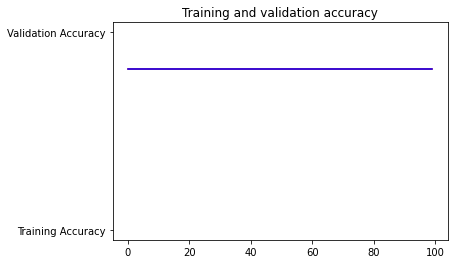

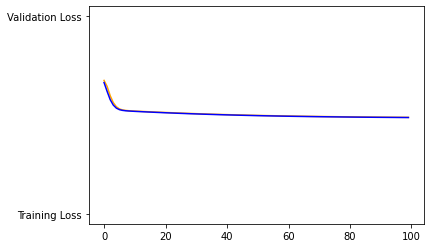

In [24]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'orange', "Training Loss")
plt.plot(epochs, val_loss, 'blue', "Validation Loss")

## Evaluate & Test Predict

In [25]:
print("Evaluate on test data")
model.evaluate(x_test, y_test)

Evaluate on test data
2084/2084 [==============================] - 2s 931us/step - loss: 0.4924 - accuracy: 0.8099


[0.4923718571662903, 0.8099281191825867]

In [41]:
test = [[0.00000953 , 2.        , 0.000000235, 9.        ]]

In [79]:
# Try to predict
test_predict = model.predict(x_test[:10])
test_predict
# threshold = 0.199

array([[0.2623121 ],
       [0.24984935],
       [0.21720046],
       [0.24010706],
       [0.24381673],
       [0.2228125 ],
       [0.22633207],
       [0.21207324],
       [0.19491798],
       [0.18595874]], dtype=float32)

In [ ]:
x_test[-5:]

In [78]:
flattest_df.iloc[:10]

,TextRank,TextRank_order,SumBasic,SumBasic_order,labels
0,0.255595,1,0.365102,3,0
1,0.245727,3,0.365102,2,1
2,0.240186,8,0.190488,10,0
3,0.246813,2,0.285732,4,1
4,0.243691,6,0.253984,5,0
5,0.231866,12,0.182551,12,0
6,0.232595,11,0.182551,11,1
7,0.221997,16,0.142866,16,1
8,0.23742,10,0.15874,14,0
9,0.224701,14,0.190488,9,0
